In [1]:
import qutip as qt
from qutip_qip.operations.gates import hadamard_transform as hadamard

import numpy as np
from matplotlib import pyplot as plt

import jax
import jax.numpy as jnp
from diffrax import Dopri5, PIDController

In [2]:
from optimize import optimize_pulses
from time_interval import TimeInterval
from objective import Objective

# Quantum Optimal Control Task

\begin{gather*}
    X(t=0) \underset{H}{\longrightarrow} X_\mathrm{trgt}=X(t=T)
\end{gather*}

\begin{gather}
    \partial_{t} X(t) = - \mathrm i \underbrace{\left( A + \sum_{k=0}^{C-1} c_k(\vec{\alpha}_k, t) B_k \right)}_{H} X(t)
\end{gather}

Closed system

\begin{array}{c|c|c|c}
 & \text{drift } A        & \text{controls } B_k & X(t, \alpha) \\\hline
 \text{state transfer}  &  H_d         &  B_k& |\Psi(t, \alpha)>\\
 \text{gate synthesis}       &  H_d         &  B_k & U(t, \alpha)   \\\hline
 \text{state transfer}      &  \hat H_d    &  \hat B_k & \rho(t, \alpha) \\
 \text{gate synthesis}     &  \hat H_d    &  \hat B_k & \hat{U}(t, \alpha)
\end{array}

\begin{gather*}
    g = \frac{1}{\|{X_\mathrm{trgt}} \|} \mathrm{tr} \left[X_\mathrm{trgt}^{\dagger} X(T, \alpha) \right]
\end{gather*}

\begin{gather*}
    f_\mathrm{SU} = \mathrm{Re}(g) \text{ and } f_\mathrm{PSU} = |g|
\end{gather*}

Open system

\begin{array}{c|c|c|c}
  & \text{drift } A   & \text{controls } B_k & X(t, \alpha) \\\hline
 \text{state transfer}     &  \hat H_d +
 \mathrm i \hat{L}    &  \hat B_k& \rho(t, \alpha) \\
 \text{map synthesis}         &   \hat H_d + \mathrm i \hat L    &  \hat B_k& \hat{U}(t, \alpha)\\
\end{array}

\begin{gather*}
    d = \frac{1}{2\|{X_\mathrm{trgt}} \|} \mathrm{tr} \left[ (X(T, \alpha) - X_\mathrm{trgt})^\dagger  (X(T, \alpha) - X_\mathrm{trgt})\right]
\end{gather*}

\begin{gather*}
    f_\mathrm{TRCDFF} = \mathrm{Re}(d)
\end{gather*}

---
# GRadient Ascent Pulse Engineering (GRAPE)
---

Slice time interval $T$ in $M$ chunks of size $\Delta t$, with piecewise constant functions $c_j(t_i, \vec \alpha) = \mathrm{const.}$ for $i \in [1, M]$

\begin{gather*}
H(t_i, \alpha) \approx A + \sum_{k=0}^{C-1} \alpha_{i,k} B_k \\

X(t_i, \alpha) = \underbrace{X_i}_{\exp(-\mathrm i H(t_i, \alpha) \Delta t)}
X_{i-1} \dots X_1 X_0
\end{gather*}

update parameters according to $\frac{\partial f^{(r)}(X(t, \alpha))}{\partial \alpha_{i,k}}$

<img src="documentation\DYNAMO.PNG" alt="dynamo" width="600"/>

---
# Chopped RAndom Basis (CRAB)
---

Update initial guess controls $c^{\text{ init}}_k(t, \vec \alpha_k)$ through parameterized update function $g_k(t, \vec \beta_k)$ expanded in some function basis i.e. Fourier:

\begin{align*}
    c^{\text{ update}}_k(t, \vec \alpha_k) &= c^{\text{ init}}_k(t, \vec \alpha_k) \cdot g_k(t, \vec \beta_k) \\ \\
    &= c^{\text{ init}}_k(t, \vec \alpha_k) \left( 1 +
    \sum_{l=1}^{\infty} A_l \sin ( \omega_l t) + B_l \cos ( \omega_l t) \right)
\end{align*}

fix + randomly choose $\omega_l$ and chop to finite basis $l\in[1, L]$

---
# Gradient Optimization of Analytic conTrols (GOAT)
---

\begin{align}
    \mathrm i\partial_{t} X = & \phantom{xx} H X\\
    \mathrm i\partial_{\alpha}\partial_{t} X = &\partial_{\alpha}  H X
\end{align}

\begin{gather*}
   {\overset{\text{RHS}}{\longrightarrow}} \begin{pmatrix}
        H & 0 \\
        \partial_{{\alpha}}{H}& H \\
    \end{pmatrix}
    \begin{pmatrix}
        X \\
        \partial_{{\alpha}}{X} \\
    \end{pmatrix}
    = \begin{pmatrix}
        H X \\
        (\partial_{{\alpha}}{H}) X + H (\partial_{{\alpha}}{X}) \\
    \end{pmatrix}
    \\ \\ =
    \begin{pmatrix}
        H & 0 & 0 & 0\\
        \partial_{\vec{\alpha}_0}{H}& H & 0 & 0 \\
        \partial_{\vec{\alpha}_1}{H}& 0 & H & 0 \\
        \vdots & 0 & 0 & \ddots \\
    \end{pmatrix}
     \begin{pmatrix}
        X \\
        \partial_{\vec{\alpha}_0}{X} \\
        \partial_{\vec{\alpha}_1}{X} \\
        \vdots \\
    \end{pmatrix}
    \\ \\ 
\end{gather*}




Algebra ...

\begin{gather*}
   =
    \begin{pmatrix}
        A + \sum_{k=0}^{C-1} c_k(\vec{\alpha}_k, t) B_k\,& 0 & 0 & 0\\
        \sum_{k=0}^{C-1} B_k\,\partial_{\vec{\alpha}_0} c_k(\vec{\alpha}_k, t)& A + \sum_{k=0}^{C-1} c_k(\vec{\alpha}_k, t) B_k\,& 0 & 0 \\
        \sum_{k=0}^{C-1} B_k\,\partial_{\vec{\alpha}_1} c_k(\vec{\alpha}_k, t)& 0 & A + \sum_{k=0}^{C-1} c_k(\vec{\alpha}_k, t) B_k\,& 0 \\
        \vdots & 0 & 0 & \ddots \\
    \end{pmatrix}
    \\ \\ =
    \begin{pmatrix}
        A & 0 & 0 & 0\\
        0& A & 0 & 0 \\
        0& 0 & A & 0 \\
        0 & 0 & 0 & \ddots \\
    \end{pmatrix}
    +\sum_{k=0}^{C-1}
    \begin{pmatrix}
        c_k(\vec{\alpha}_k, t) B_k\,& 0 & 0 & 0\\
        B_k\,\partial_{\vec{\alpha}_0} c_k(\vec{\alpha}_k, t)&  c_k(\vec{\alpha}_k, t) B_k\,& 0 & 0 \\
        B_k\,\partial_{\vec{\alpha}_1} c_k(\vec{\alpha}_k, t)& 0 & c_k(\vec{\alpha}_k, t) B_k\,& 0 \\
        \vdots & 0 & 0 & \ddots \\
    \end{pmatrix}
    
    
\end{gather*}

\begin{gather*} =
    (\mathbf{I} \otimes A) + \sum_{k=0}^{C-1}
    (\mathbf{I} \otimes B_k) c_k(\vec{\alpha}_k, t) +
    \begin{pmatrix}
        0 & 0 &  \\
        B_0\, \partial_{\vec{\alpha}_0} c_0(\vec{\alpha}_0, t)& 0 & \\
        B_1\,\partial_{\vec{\alpha}_1} c_1(\vec{\alpha}_1, t)& 0  & \\
        \vdots &  & \ddots \\
    \end{pmatrix}
    \\ \\ =
    (\mathbf{I} \otimes A) + \sum_{k=0}^{C-1}
    (\mathbf{I} \otimes B_k) c_k(\vec{\alpha}_k, t) +
    \sum_{k=0}^{C-1} (\mathbf{1}_{0,k+1} \otimes B_k) \partial_{{\alpha}_{k}} c_k(\vec{\alpha}_k, t)
\end{gather*}

Details ...
where $\mathbf{1}_{0,k+1}$ is the zero square matrix with only one entry in the first column at row index $1 + (k \cdot M + l)$ set to one, and ($l$ index of) $M$

is the number of varaible parameters for each control amplitude $c_k(\vec{\alpha}_k, t)$, i.e. for a superposition of Gaussian pulses with three variable parameters each $\rightarrow M = 3 \cdot m$:
\begin{gather*}
    c_k(\vec{\alpha}_k, t) = \sum_{l=0}^{M-1} A_{k,l} \exp\left({\frac{-(t-\tau_{k,l})^2}{\sigma_{k,l}^2}}\right)
\end{gather*}

Expressing the Hamiltonian in this form makes it comfortable to implement it using QuTiP
\begin{gather*}
    \underbrace{(\mathbf{I} \otimes A)}_{\mathrm{QobjEvo(}\tilde{H}_d,f(x)=1)}
     + \sum_{k=0}^{C-1}\underbrace{(\mathbf{I} \otimes B_k) c_k(\vec{\alpha}_k, t)}_{\mathrm{QobjEvo(}\tilde{H}_k,c_k(\vec{\alpha}_k, t))}
     + \sum_{k=0}^{C-1} \sum_{l=0}^{M-1} \underbrace{(\mathbf{1}_{0,k+1} \otimes B_k) \partial_{{\alpha}_{k,l}} c_k(\vec{\alpha}_k, t)}_{\mathrm{QobjEvo(}\tilde{H}_k,\partial_{{\alpha}_{k,l}} c_k(\vec{\alpha}_k, t))}
\end{gather*}

Complexity ...

We have now $1 + C + C \cdot M = O(C \cdot M)$ summands, i.e. the term grows linear with the number of parameters $N_{\mathrm{para}} = C \cdot M$

The size of the matrix however grows with $O(N_{\mathrm{para}} \cdot \mathrm{dim}(A))$

---
# Example: Hadamard Gate
---

\begin{gather*}
    U(t=0) = \mathbf{I} \longrightarrow U(T) = \mathrm{H} = \frac{1}{\sqrt{2}} \begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}
\end{gather*}

In [3]:
initial = qt.qeye(2)
target  = hadamard()

initial = qt.sprepost(initial, initial.dag())
target  = qt.sprepost(target , target.dag() )

objective = Objective(initial, ... , target)

\begin{gather}
    \partial_{t} U(t) =-\frac{i}{\hbar}[H(\vec{\alpha}, t), U(t)]+ \frac{1}{2} \left[2 C U(t) C^\dagger - U(t) C^\dagger C - C^\dagger C U(t)\right] \\
\end{gather}

\begin{gather*}
    H(\vec{\alpha}, t) = \underbrace{
            \frac{1}{2} \left(\omega \sigma_z +  \Delta \sigma_x\right)
        }_{H_d} 
    + H_c(\vec{\alpha}, t) \text{ and }C = \sqrt \gamma a
\end{gather*}

Time independent drift Hamiltonian

In [4]:
σx = qt.sigmax()
σy = qt.sigmay()
σz = qt.sigmaz()

ω, Δ, γ, π = 0.1, 1.0, 0.1, np.pi

Hd = 1/2 * (ω * σz + Δ * σx)

H_d =  qt.liouvillian(H=Hd, c_ops=[np.sqrt(γ) * qt.sigmam()])

In [5]:
num_ts = 100
interval = TimeInterval(evo_time= 2*π, num_tslots=num_ts)

In [6]:
Hc  = [σx, σy, σz]
H_c = [qt.liouvillian(H) for H in Hc]

init_x = np.ones(num_ts)
init_y = np.ones(num_ts)
init_z = np.ones(num_ts)

H = [ H_d,
     [H_c[0], init_x],
     [H_c[1], init_y],
     [H_c[2], init_z]]

10.1%. Run time:   0.00s. Est. time left: 00:00:00:00
20.2%. Run time:   0.00s. Est. time left: 00:00:00:00
30.3%. Run time:   0.00s. Est. time left: 00:00:00:00
40.4%. Run time:   0.01s. Est. time left: 00:00:00:00
50.5%. Run time:   0.01s. Est. time left: 00:00:00:00
60.6%. Run time:   0.01s. Est. time left: 00:00:00:00
70.7%. Run time:   0.01s. Est. time left: 00:00:00:00
80.8%. Run time:   0.01s. Est. time left: 00:00:00:00
90.9%. Run time:   0.02s. Est. time left: 00:00:00:00
100.0%. Run time:   0.02s. Est. time left: 00:00:00:00
Total run time:   0.02s


(<Figure size 640x480 with 2 Axes>, <Axes: >)

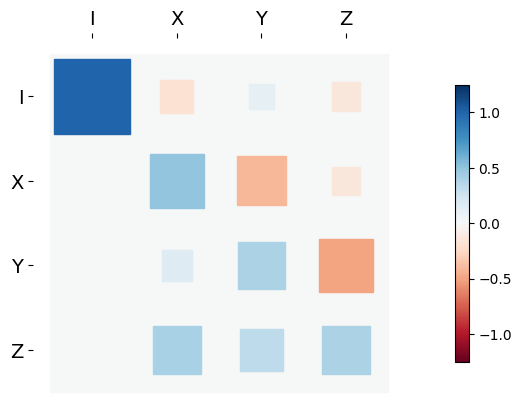

In [7]:
init_evo = qt.mesolve(H, initial, interval.tlist)

qt.hinton(init_evo.final_state)

# QuTiP GRAPE

In [8]:
res_grape = optimize_pulses(
    objectives = [Objective(initial, H, target)],
    pulse_options={
        "ctrl_x": {
            "guess":  init_x,
            "bounds": [-1, 1],
        },
        "ctrl_y": {
            "guess":  init_y,
            "bounds": [-1, 1],
        },
        "ctrl_z": {
            "guess":  init_z,
            "bounds": [-1, 1],
        }
    },
    time_interval = interval,
    algorithm_kwargs = {
        "alg": "GRAPE",
        "fid_err_targ": 0.01,
        "disp": False,
    }
)

In [9]:
res_grape

Control Optimization Result
       --------------------------
       - Started at 2023-11-08 17:01:58
       - Number of objectives: 1
       - Final fidelity error: 0.0439377751196086
       - Final parameters: [[ 0.99991545  0.99991321  0.9995385   0.99992033  0.99810283  0.99969499
  0.97012454  0.94278158  0.9064599   0.87240861  0.90137676  0.99617005
  0.76288822  0.84542857  0.91178092  0.76295077  0.9776711   0.94562056
  0.99907398  0.9988139   0.99998925  0.99999976  0.99999207  0.99999377
  0.99999518  0.99999595  0.99999697  0.99999733  0.99999521  0.99999212
  0.99998972  0.99998826  0.99998772  0.99998808  0.99998942  0.99999072
  0.99671053  0.98711879  0.98202548  0.97698635  0.98020077  0.99007851
  0.99995988  0.80627242  0.65200952  0.99933544  1.          1.
  1.          0.99996215  0.99979398  0.99942085  0.98775828  0.98611038
  0.99110989  1.          1.          1.          1.          1.
  1.          1.          0.99987335  0.99910338  0.99173364  0.98693635


(<Figure size 1500x400 with 6 Axes>, <Axes: title={'center': 'Target'}>)

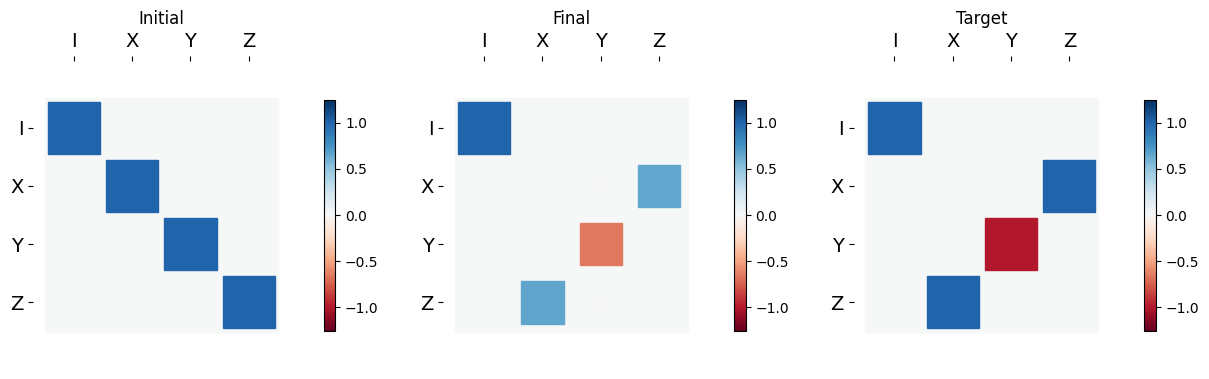

In [10]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 4))
ax0.set_title('Initial')
ax1.set_title('Final')
ax2.set_title('Target')

qt.hinton(initial, ax=ax0)
qt.hinton(res_grape.final_states[0], ax=ax1)
qt.hinton(target, ax=ax2)

# QuTiP CRAB

In [11]:
res_crab = optimize_pulses(
    objectives = [Objective(initial, H, target)],
    pulse_options={
        "ctrl_x": {
            "guess":  init_x,
            "bounds": [-1, 1],
        },
        "ctrl_y": {
            "guess":  init_y,
            "bounds": [-1, 1],
        },
        "ctrl_z": {
            "guess":  init_z,
            "bounds": [-1, 1],
        }
    },
    time_interval = interval,
    algorithm_kwargs = {
        "alg": "CRAB",
        "fid_err_targ": 0.01,
    }
)

In [12]:
res_crab

Control Optimization Result
       --------------------------
       - Started at 2023-11-08 17:02:05
       - Number of objectives: 1
       - Final fidelity error: 0.048261793578351954
       - Final parameters: [[ 0.99170299  0.99171211  0.9911174   0.98980708  0.98752611  0.98381306
  0.97789033  0.96849476  0.95364669  0.93039749  0.89469177  0.841635
  0.76656679  0.66712162  0.54562994  0.41020429  0.27308416  0.14687243
  0.04110836 -0.03899745 -0.09184165 -0.11797131 -0.11888767 -0.09646118
 -0.0528935   0.00899762  0.08544666  0.17163987  0.26203244  0.35105604
  0.43395195  0.50737973  0.56959278  0.62021383  0.65980114  0.68940397
  0.71022406  0.72341415  0.72999489  0.73085641  0.72681374  0.71869193
  0.70742023  0.69411399  0.68012116  0.66701114  0.65649251  0.65026114
  0.64979828  0.6561532   0.66975246  0.69027998  0.71666651  0.74721311
  0.77984255  0.81243037  0.84313107  0.87061042  0.89413164  0.91350099
  0.92892395  0.94083576  0.94975405  0.9561746   0.96050

(<Figure size 1500x400 with 6 Axes>, <Axes: title={'center': 'Target'}>)

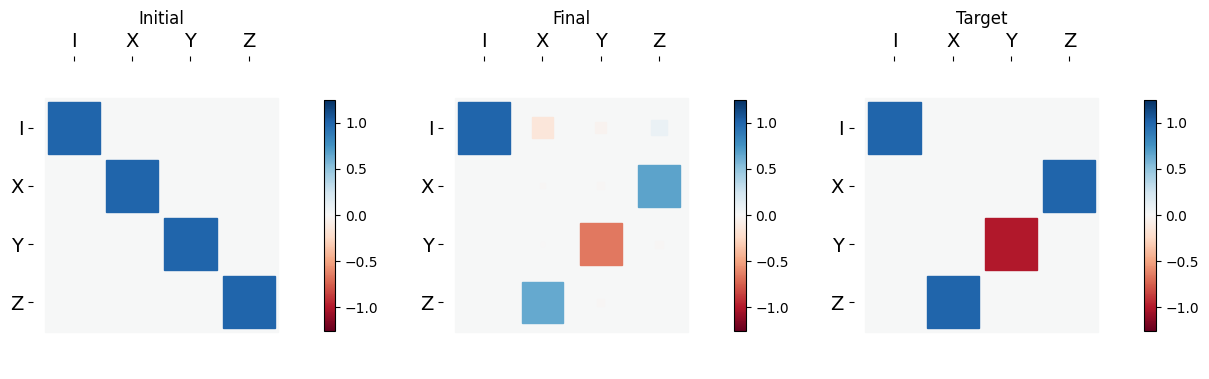

In [13]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 4))
ax0.set_title('Initial')
ax1.set_title('Final')
ax2.set_title('Target')

qt.hinton(initial, ax=ax0)
qt.hinton(res_crab.final_states[0], ax=ax1)
qt.hinton(target, ax=ax2)

In [14]:
def plot_result(res, title, y_labels=["$\sigma_x$", "$\sigma_y$", "$\sigma_z$"]):
    fig, ax = plt.subplots(len(res.optimized_controls), 1, figsize=(15, 12), sharex=True)
    ax[0].set_title(title, fontsize=20)

    for i in range(len(res.optimized_controls)):
        ax[i].xaxis.set_label_text('Time')
        ax[i].yaxis.set_label_text('Control ' + y_labels[i])
        ax[i].plot(res.time_interval.tlist, res.guess_controls[i], label='Guess')
        ax[i].plot(res.time_interval.tlist, res.optimized_controls[i], label='Optimized')
        ax[i].legend()

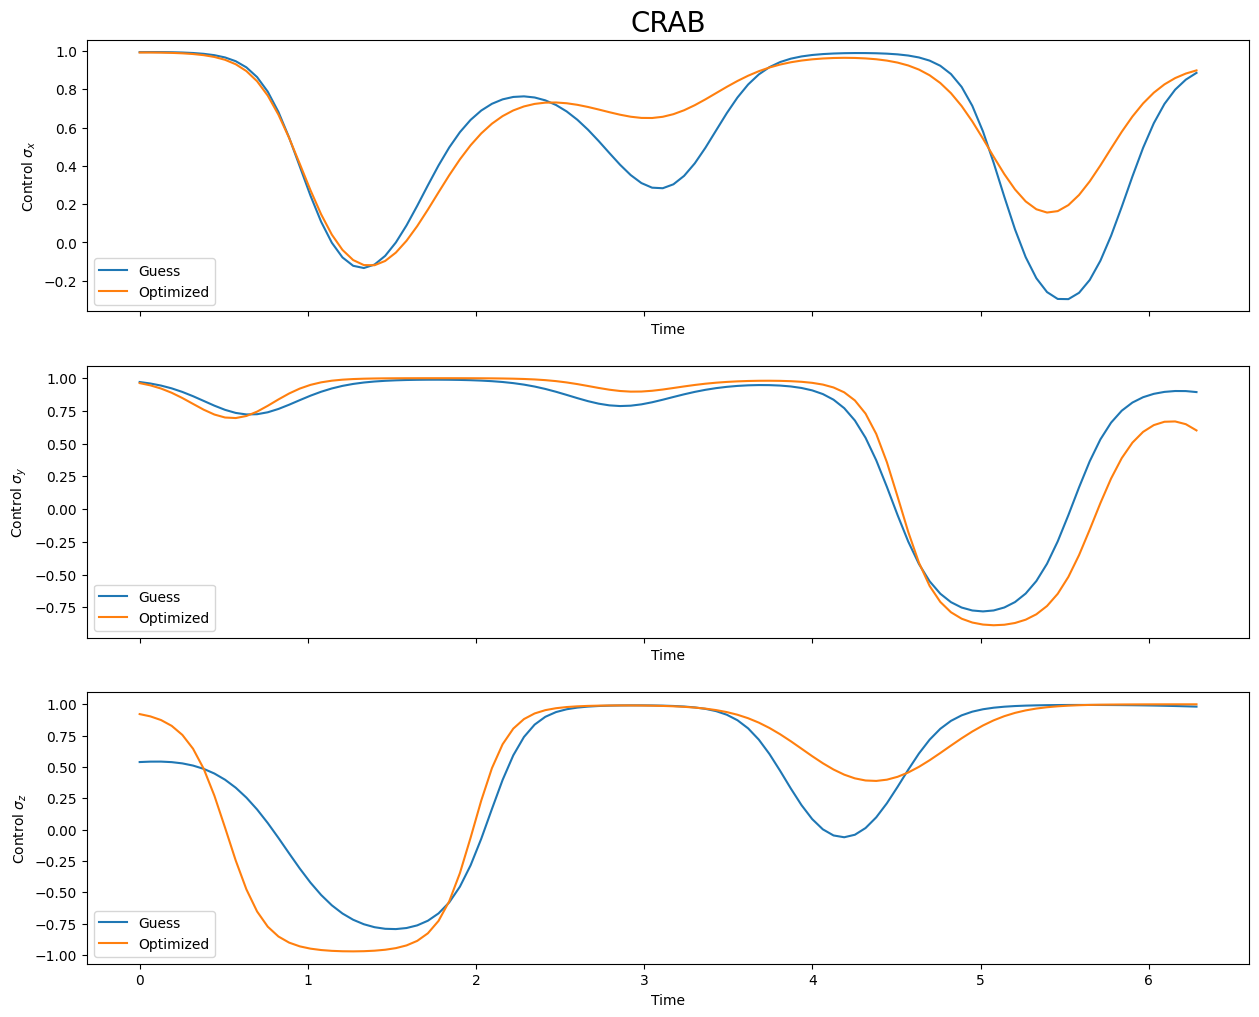

In [15]:
plot_result(res_crab, "CRAB")

# QuTiP GOAT

\begin{gather*}
H_c(\vec{\alpha}, t) =
\underbrace{c_0(\vec{\alpha}_0, t) \sigma_x}_{H_0(t, \vec{\alpha})}  
    +\underbrace{c_1(\vec{\alpha}_1, t) \sigma_y}_{H_1(t, \vec{\alpha})} 
    +\underbrace{c_2(\vec{\alpha}_2, t) \sigma_z}_{H_2(t, \vec{\alpha})} \\ \\
    c_k(\vec{\alpha}, t) = \alpha_{k,0} \cdot \sin(\alpha_{k,1} t + \alpha_{k,2})
\end{gather*}

In [16]:
def sin(t, α):
    return α[0] * np.sin(α[1] * t + α[2])

def grad_sin(t, α, idx):
    if idx==0: return np.sin(α[1] * t + α[2])
    if idx==1: return α[0] * np.cos(α[1] * t + α[2]) * t
    if idx==2: return α[0] * np.cos(α[1] * t + α[2])
    if idx==3: return α[0] * np.cos(α[1] * t + α[2]) * α[1] # w.r.t. time

In [17]:
sin_x = lambda t, p: sin(t, p)
sin_y = lambda t, q: sin(t, q)
sin_z = lambda t, r: sin(t, r)

In [18]:
Hc  = [σx, σy, σz]
H_c = [qt.liouvillian(H) for H in Hc]

H = [ H_d,
     [H_c[0], sin_x, {"grad": grad_sin}],
     [H_c[1], sin_y, {"grad": grad_sin}],
     [H_c[2], sin_z, {"grad": grad_sin}]]

10.1%. Run time:   0.00s. Est. time left: 00:00:00:00
20.2%. Run time:   0.01s. Est. time left: 00:00:00:00
30.3%. Run time:   0.01s. Est. time left: 00:00:00:00
40.4%. Run time:   0.01s. Est. time left: 00:00:00:00
50.5%. Run time:   0.02s. Est. time left: 00:00:00:00
60.6%. Run time:   0.02s. Est. time left: 00:00:00:00
70.7%. Run time:   0.02s. Est. time left: 00:00:00:00
80.8%. Run time:   0.03s. Est. time left: 00:00:00:00
90.9%. Run time:   0.03s. Est. time left: 00:00:00:00
100.0%. Run time:   0.03s. Est. time left: 00:00:00:00
Total run time:   0.03s


(<Figure size 640x480 with 2 Axes>, <Axes: >)

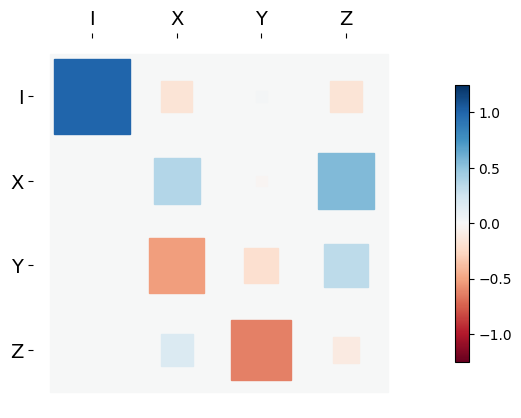

In [19]:
p_init = [1, 1, 0]
q_init = [1, 1, 0]
r_init = [1, 1, 0]

init_evo = qt.mesolve(H, initial, interval.tlist,
                      options={'normalize_output': False},
                      args={"p": p_init, "q": q_init, "r": r_init})

qt.hinton(init_evo.final_state)

In [20]:
res_goat = optimize_pulses(
    objectives = [Objective(initial, H, target)],
    pulse_options={
        "p": {
            "guess":  p_init, # p0 * sin(p1 * t + p2)
            "bounds": [(-1, 1), (0, 1), (0, 2*np.pi)],
        },
        "q": {
            "guess":  q_init, # q0 * sin(q1 * t + q2)
            "bounds": [(-1, 1), (0, 1), (0, 2*np.pi)],
        },
        "r": {
            "guess":  r_init, # r0 * sin(r1 * t + r2)
            "bounds": [(-1, 1), (0, 1), (0, 2*np.pi)],
        }
    },
    time_interval = interval,
    algorithm_kwargs = {
        "alg": "GOAT",
        "fid_err_targ": 0.01,
        "disp": True,
        "max_iter": 10,
        "seed": 1,
    },
)

NameError: name 'g' is not defined

In [ ]:
res_goat

Control Optimization Result
--------------------------
- Started at 2023-11-08 14:18:34
- Number of objectives: 1
- Final fidelity error: 0.043957380868878175
- Final parameters: [[0.9964819855689503, 0.2899606660244335, 0.9039889910700316], [0.2899606660244335, 0.9039889910700316, 0.7840699363944933], [0.9039889910700316, 0.7840699363944933, 0.7328540321474514]]
- Number of iterations: 10
- Reason for termination: ['requested number of basinhopping iterations completed successfully']
- Ended at 2023-11-08 14:18:50 (15.8037s)

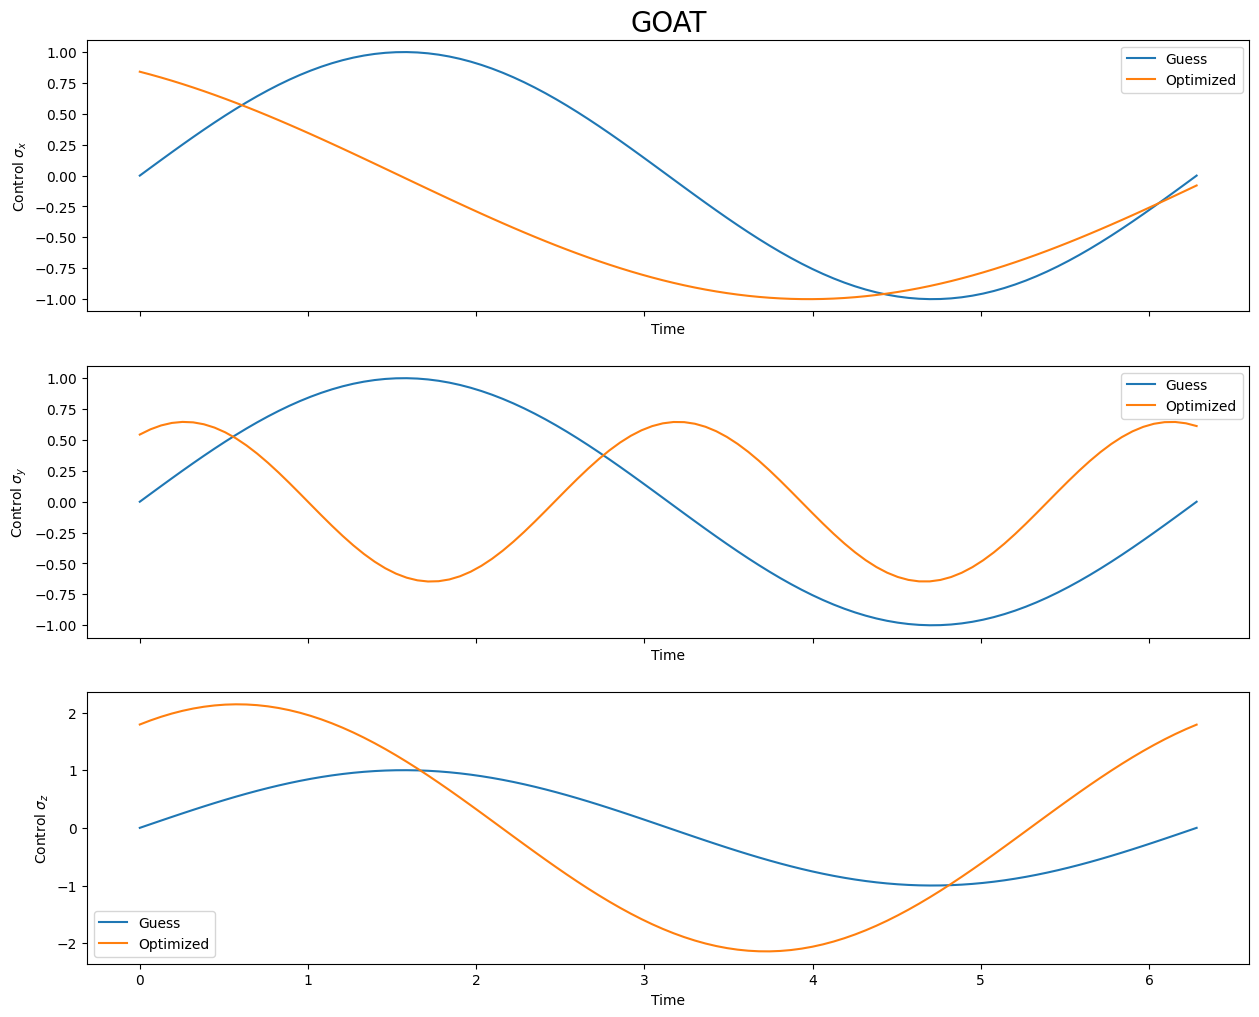

In [ ]:
plot_result(res_goat, "GOAT")

In [20]:
res_goat = optimize_pulses(
    objectives = [Objective(initial, H, target)],
    pulse_options={
        "p": {
            "guess":  p_init, # p0 * sin(p1 * t + p2)
            "bounds": [(-1, 1), (0, 1), (0, 2*np.pi)],
        },
        "q": {
            "guess":  q_init, # q0 * sin(q1 * t + q2)
            "bounds": [(-1, 1), (0, 1), (0, 2*np.pi)],
        },
        "r": {
            "guess":  r_init, # r0 * sin(r1 * t + r2)
            "bounds": [(-1, 1), (0, 1), (0, 2*np.pi)],
        }
    },
    time_interval = interval,
    time_options={
        #"guess":  [interval.evo_time],
        #"bounds": [(0, interval.evo_time)],
    },
    algorithm_kwargs = {
        "alg": "GOAT",
        "fid_err_targ": 0.01,
        "disp": True,
        "max_iter": 10,
        "seed": 0,
    },
    integrator_kwargs = {
        "atol": 1e-5,
        "rtol": 1e-5,
        "method": "dop853",
    },
)

KeyboardInterrupt: 

In [47]:
res_goat

Control Optimization Result
--------------------------
- Started at 2023-11-08 15:28:44
- Number of objectives: 1
- Final fidelity error: 0.01993803372414761
- Final parameters: [[0.9783484000617632, 0.9108695458052739, 0.5573920683610817], [0.9108695458052739, 0.5573920683610817, 0.9964072710066866], [0.5573920683610817, 0.9964072710066866, 0.741833594412957], [0.9964072710066866]]
- Number of iterations: 10
- Reason for termination: ['requested number of basinhopping iterations completed successfully']
- Ended at 2023-11-08 15:29:07 (23.251s)

# QuTiP JAX

In [21]:
from diffrax import Dopri5, Dopri8, Tsit5, PIDController

In [22]:
def sin(t, α):
    return α[0] * jnp.sin(α[1] * t + α[2])

In [23]:
@jax.jit
def sin_x(t, p, **kwargs):
    return sin(t, p)

@jax.jit
def sin_y(t, q, **kwargs):
    return sin(t, q)

@jax.jit
def sin_z(t, r, **kwargs):
    return sin(t, r)

In [24]:
Hc  = [σx, σy, σz]
H_c = [qt.liouvillian(H) for H in Hc]

H = [ H_d,
     [H_c[0], sin_x],
     [H_c[1], sin_y],
     [H_c[2], sin_z]]

In [25]:
res_joat = optimize_pulses(
    objectives = [Objective(initial, H, target)],
    pulse_options={
        "p": {
            "guess":  p_init,
            "bounds": [(-1, 1), (0, 1), (0, 2*np.pi)],
        },
        "q": {
            "guess":  q_init,
            "bounds": [(-1, 1), (0, 1), (0, 2*np.pi)],
        },
        "r": {
            "guess":  r_init,
            "bounds": [(-1, 1), (0, 1), (0, 2*np.pi)],
        }
    },
    time_interval = interval,
    time_options={
        #"guess":  [interval.evo_time],
        #"bounds": [(0, interval.evo_time)],
    },
    algorithm_kwargs = {
        "alg": "JOAT",
        "fid_err_targ": 0.01,
        "disp": True,
        "max_iter": 100,
        "seed": 0,
    },
    integrator_kwargs = {
        "stepsize_controller": PIDController(
            atol = 1e-5,
            rtol = 1e-5,
        ),
        "solver": Dopri8(),
    },
)

minimizer step, infidelity: 0.27594
max_wall_time reached, terminating minimization
optimizer step, infidelity: 0.27594, took 195.56 seconds
max_wall_time reached, terminating optimization
minimizer step, infidelity: 0.37868
max_wall_time reached, terminating minimization
optimizer step, infidelity: 0.37868, took 0.22 seconds
max_wall_time reached, terminating optimization


In [53]:
res_joat

Control Optimization Result
--------------------------
- Started at 2023-11-08 15:29:28
- Number of objectives: 1
- Final fidelity error: 0.0076496372972240725
- Final parameters: [[0.26109669771812455, 0.17786478789093418, 1.9011432284515037], [0.17786478789093418, 1.9011432284515037, 0.9770040484422033], [1.9011432284515037, 0.9770040484422033, 0.9971955993564665], [0.9770040484422033]]
- Number of iterations: 8
- Reason for termination: fid_err_targ reached
- Ended at 2023-11-08 15:30:52 (84.0225s)

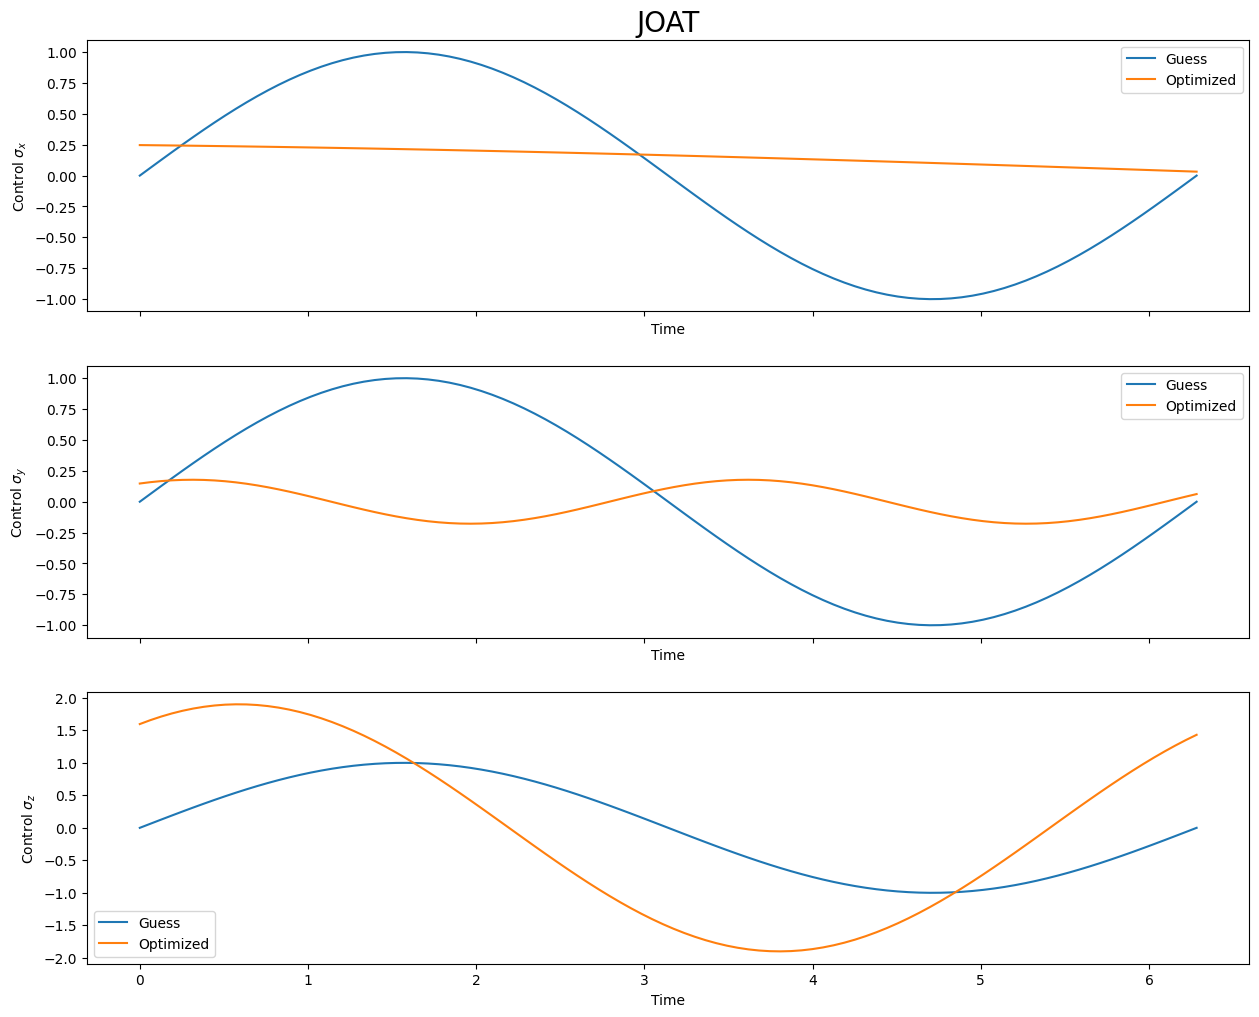

In [54]:
plot_result(res_joat, "JOAT")